# **Euler–Maruyama method**

기초적인 SDE solution  
${\displaystyle \,Y_{n+1}=Y_{n}+a(Y_{n},\tau _{n})\,\Delta t+b(Y_{n},\tau _{n})\,\Delta W_{n},}$

# ***The "FRKI" method (first-order Runge-Kutta method involving the Ito coefficient).***

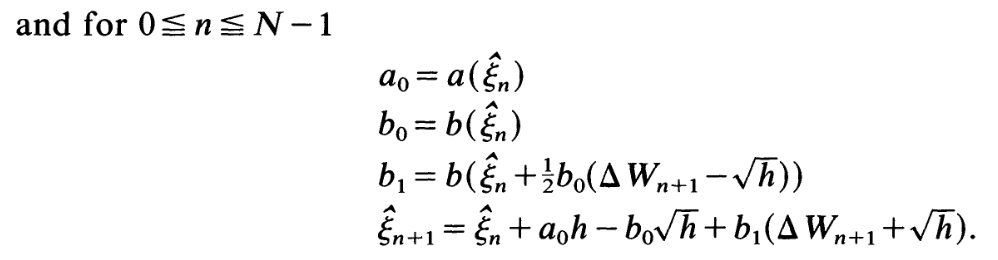


b텀에 해당되는 노이즈의 세기가 $\xi$에 영향을 주지 않는 경우 노의즈에 해당되는 텀은 사라지고 RKHG 방법으로 변하게 된다.

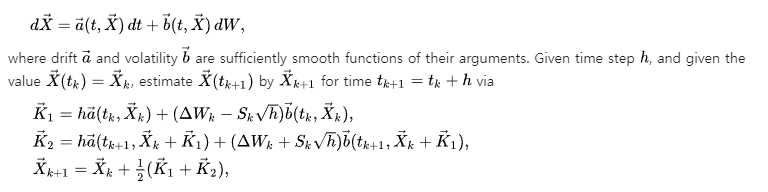  
[Runge–Kutta method (SDE)](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_(SDE))

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [194]:
# @jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y



def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

In [195]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc




In [196]:
# @jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

# @jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

# @jit(nopython=True)
def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta



In [197]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [563]:
K = 1
t_end = 1000
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.1
b = 1.01
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))


In [564]:
theta_s = sol[:,:N]
dtheta_s = sol[:,N:2*N] 

In [565]:
rabs_ = np.mean(np.exp(theta_s.T*1j),axis=0)
rabs = rabs_[len(t)//2:]
r = np.abs(rabs)

In [566]:
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [567]:
sigma,np.mean(r)

(0.9977421211761967, 0.9977649989597932)

In [568]:
b

1.01

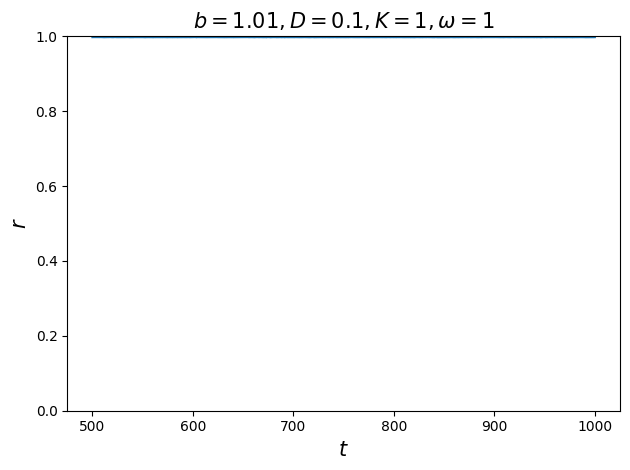

In [569]:
plt.plot(t[len(t)//2:],r)
plt.xlabel('$t$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.title(rf'$b={b},D={D},K={K},\omega=1$',fontsize=15)
plt.ylim(0.0,1)
plt.tight_layout()

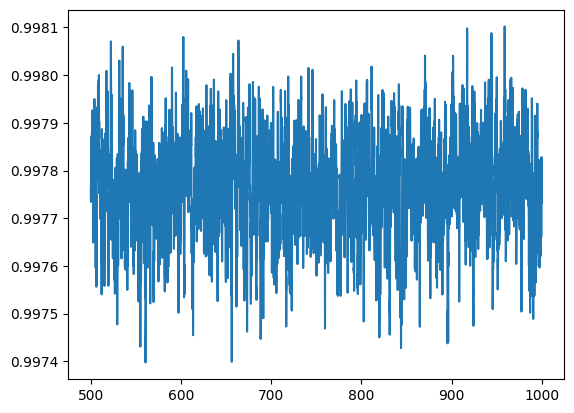

In [570]:
plt.plot(t[len(t)//2:],r)

In [571]:
h,b_ = np.histogram(np.sin(theta_s[len(t)//2,:]),bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(np.sin(theta_s[len(t)//2+i,:]),bins=b_)
    hs.append(h)
hs = np.array(hs)
h

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,
        0,  0,  1,  2,  1,  0,  0,  0,  1,  3,  3,  0,  3,  1,  0,  5,  4,
        3,  4,  8,  3,  3,  5,  4,  2,  5,  5, 10,  4,  6,  5, 11,  8,  9,
        8, 12, 15, 10, 14, 19, 15, 17, 18, 19, 18, 31, 30, 32, 17, 17, 32,
       31, 28, 30, 31, 30, 33, 38, 30, 37, 43, 36, 35, 36, 36, 78],
      dtype=int64)

In [572]:
dtheta_s = np.diff(theta_s/dt,axis=0)

In [573]:
dtheta_s = np.diff(theta_s,axis=1)
sum_time = 10
dtheta_c = np.cumsum(dtheta_s[:], axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
diff_avg_dtheta = np.diff(avg_dtheta, axis=1)

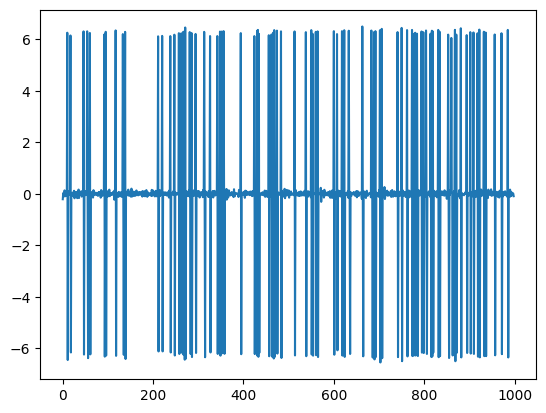

In [574]:
plt.plot(avg_dtheta[-1])

In [575]:
np.mean(avg_dtheta[-1])

-0.0001891829598237239

In [576]:
avg_dtheta.shape

(9991, 999)

In [577]:
b_theta = np.arcsin(b_)

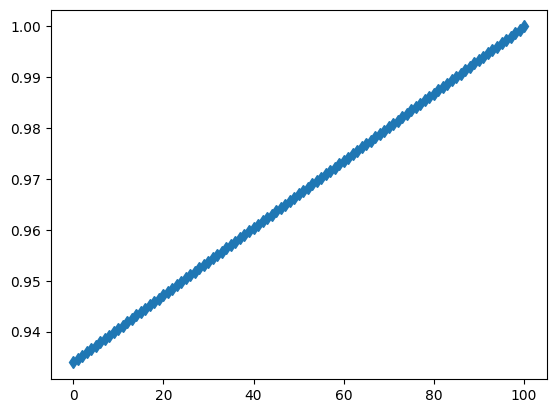

In [578]:
plt.plot(b_,'d')

In [579]:
A = theta_s%(2*np.pi)

In [580]:
h,b_ = np.histogram(A[len(t)//2,:],bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(A[len(t)//2+i,:],bins=b_)
    hs.append(h)
hs = np.array(hs)

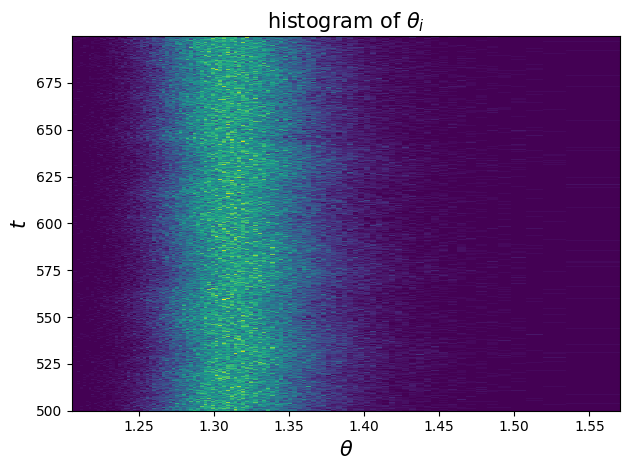

In [583]:
plt.pcolormesh(b_theta,t[len(t)//2:len(t)//2+2000],hs[1:])
plt.gca().set_aspect('auto')
plt.ylabel(r'$t$',fontsize=15)
plt.xlabel(r'$\theta$',fontsize=15)
plt.title(r'histogram of $\theta_i$',fontsize=15)
plt.tight_layout()

(array([  3.,   4.,   0.,   1.,   3.,   2.,   1.,   0.,   3.,   4.,   0.,
          4.,   0.,   1.,   4.,   1.,   0.,   1.,   0.,   3.,   3.,   2.,
          3.,   1.,   2.,   1.,   1.,   4.,   1.,   1.,   4.,   0.,   1.,
          1.,   2.,   0.,   1.,   0.,   4.,   2.,   4.,   2.,   2.,   3.,
          3.,   0.,   3.,   1.,   3.,   1.,   3.,   2.,   5.,   5.,   2.,
          1.,   0.,   3.,   2.,   2.,   3.,   5.,   1.,   1.,   7.,   2.,
          3.,   2.,   6.,   8.,   8.,   2.,   7.,   3.,   9.,  12.,  11.,
         17.,  15.,   8.,  15.,  13.,   9.,  24.,  16.,  24.,  20.,  26.,
         26.,  31.,  26.,  29.,  35.,  34.,  48.,  47.,  50.,  63.,  57.,
        161.]),
 array([-9.99003516e-01, -9.79013498e-01, -9.59023479e-01, -9.39033461e-01,
        -9.19043443e-01, -8.99053425e-01, -8.79063406e-01, -8.59073388e-01,
        -8.39083370e-01, -8.19093352e-01, -7.99103333e-01, -7.79113315e-01,
        -7.59123297e-01, -7.39133279e-01, -7.19143261e-01, -6.99153242e-01,
        -6.791

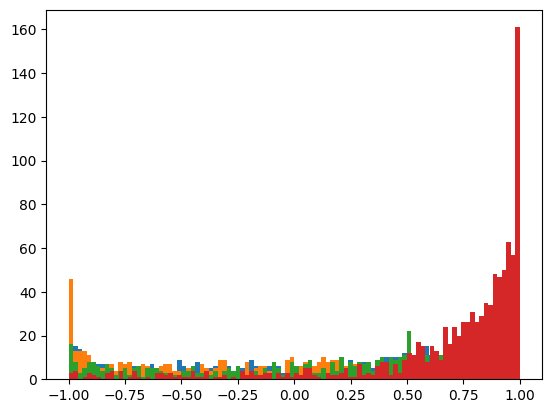

In [430]:

plt.hist(np.sin(theta_s[len(t)//2,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+10,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+20,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+30,:]),bins=100)